## Research Hypothesis

**Hypothesis:** We want to test if we can predict the location (specific location) of a tsunami based on several criteria, e.g:
- Date
- Earthquake Magnitude
- Country
- Water Height
- etc.

## Default imports

In [2]:
import os
import pandas as pd

# from bs4 import BeautifulSoup

from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as ec
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException

import seaborn as sns

from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import matplotlib.pyplot as plt
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6)

## Crawling and fetching data from external website

We will configure webdriver (Selenium) with headless option to crawl to ```ngdc.noaa.gov``` and collect out relevant data.<br>
The website loades tables in a weird manner, it only renders the rows and columns that fit the screen (even in the code),<br>
so an alternative I picked was to click dynamically on a button that downloads a ```.tsv``` file locally.

We verify that there are no other ```.tsv``` files in the local directory and if there are we remove them and then downloading the update file.

In [7]:
options = webdriver.ChromeOptions()
options.add_argument('--headless')

# Max = 2022, Min = 1992 (Last 30 years)
crawl_url = "https://www.ngdc.noaa.gov/hazel/view/hazards/tsunami/event-data?maxYear=2022&minYear=1992"

browser = webdriver.Chrome(ChromeDriverManager().install(), options=options)
try:
  files = os.scandir('./')
  for file in files:
    if file.is_file() and file.name.endswith('.tsv'):
      os.remove(file)

  browser.get(crawl_url)
  timeout = 20
  WebDriverWait(browser, timeout).until(ec.presence_of_element_located((By.CLASS_NAME, 'haz-grid')))
  button = browser.find_element(by=By.CLASS_NAME, value='fa-file-download')
  button.click()
except TimeoutException:
  print("Can't handle...")

# Couldn't make if to work because of the explanation above:

# titles = []
# data = []

# crawl_soup = BeautifulSoup(browser.page_source, 'html.parser')
# soup_rows = crawl_soup.find('div', {'class': 'haz-grid'})
# children = soup_rows.findAll('div', recursive=False)
# inner = children[1].find('div', recursive=False)
# sec_inner = inner.findAll('div', recursive=False)
# soup_column_names_e = sec_inner[0].find('div', recurise=False)
# soup_column_names_e2 = soup_column_names_e[0].find('div', recurise=False)
# soup_column_names_div = soup_column_names_e2.find('div', recurise=False)
# soup_data_rows = sec_inner[1]

# for div in soup_column_names_div:
#   inner_div = div.find('div', recursive=False)
#   second_div = inner_div.find('div', recursive=False)
#   titles.append(second_div.text)

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [/Users/orrgoren/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache
/var/folders/27/lh1n32415qgg2sysk9tssv580000gq/T/ipykernel_30191/554252747.py:7: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  browser = webdriver.Chrome(ChromeDriverManager().install(), options=options)


## Create the DataFrame

I'm validating that we have a local ```.tsv``` file and we convert it to a DataFrame.<br>
I remove the first row and first column that are useless to our data.<br>
I save an instance of the original DataFrame so I can use it later.

In [22]:
f_name = ''
path = './'
obj = os.scandir(path);

for entry in obj:
  if entry.is_file() and entry.name.endswith('.tsv'):
    f_name = entry.name

df = pd.read_csv(f_name, delimiter="\t")
df = df.iloc[: , 1:] # Remove first column
df = df.iloc[1: , :] # Remove first row

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409 entries, 1 to 409
Data columns (total 45 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Year                                409 non-null    float64
 1   Mo                                  407 non-null    float64
 2   Dy                                  407 non-null    float64
 3   Hr                                  357 non-null    float64
 4   Mn                                  355 non-null    float64
 5   Sec                                 334 non-null    float64
 6   Tsunami Event Validity              409 non-null    float64
 7   Tsunami Cause Code                  409 non-null    float64
 8   Earthquake Magnitude                327 non-null    float64
 9   Vol                                 23 non-null     float64
 10  More Info                           0 non-null      float64
 11  Deposits                            409 non-n

## Cleaning The Data recieved

I'm dropping the useless columns, those with a lot of null values or duplicate data, for example:<br>
Total Death and Death are equal with their values.<br>
I stated that I want columns with atleast 300 values inside and not less.

In [24]:
# Remove Duplicates
df.drop_duplicates()
# Remove nulls
df.dropna(axis=1, thresh=300, inplace=True)
# Fulling 0 because null's are irrelevant for us
df.fillna(0, inplace=True)

After cleaning we work with around **6,500** values.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409 entries, 1 to 409
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      409 non-null    float64
 1   Mo                        409 non-null    float64
 2   Dy                        409 non-null    float64
 3   Hr                        409 non-null    float64
 4   Mn                        409 non-null    float64
 5   Sec                       409 non-null    float64
 6   Tsunami Event Validity    409 non-null    float64
 7   Tsunami Cause Code        409 non-null    float64
 8   Earthquake Magnitude      409 non-null    float64
 9   Deposits                  409 non-null    float64
 10  Country                   409 non-null    object 
 11  Location Name             409 non-null    object 
 12  Latitude                  409 non-null    float64
 13  Longitude                 409 non-null    float64
 14  Maximum Wa

## EDA

The first chart is showing us the number of tsunami's divided by the countries.

#### Country vs. Tsunami

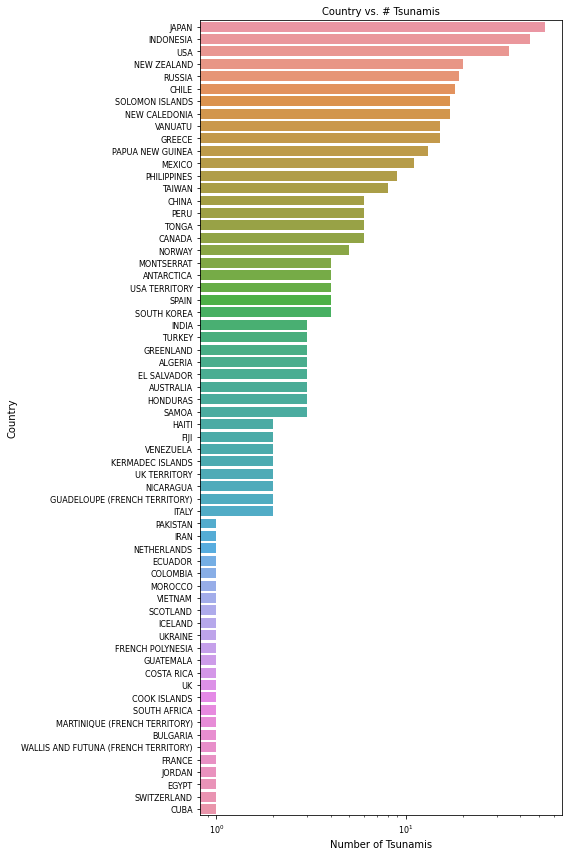

In [18]:
plt.figure(figsize=(8,12))
countries = df["Country"].value_counts().keys().tolist()
ax = sns.countplot(y="Country", data = df, order = df["Country"].value_counts().index)
ax.set_xscale("log")
ax.axes.set_title("Country vs. # Tsunamis", fontsize = 10)
ax.set_xlabel("Number of Tsunamis", fontsize = 10)
ax.set_ylabel("Country", fontsize = 10)
ax.tick_params(labelsize = 8)
ax.set_yticklabels(countries, rotation = 0, fontsize = 8)
plt.tight_layout()
plt.show()

### Earthquake Magnitude vs. Tsunami

The following chart is showing us the # of tsunami's vs the earthquake magnitude.

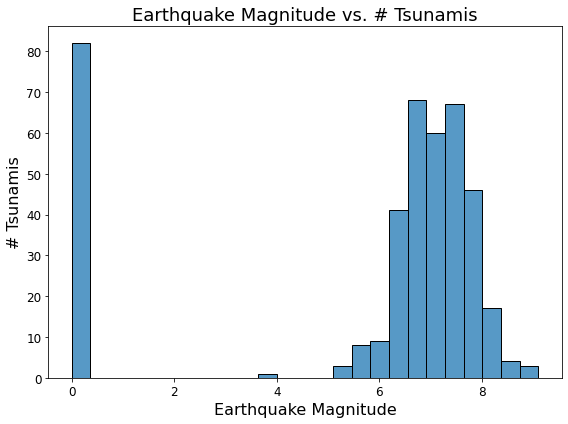

In [19]:
plt.figure(figsize=(8,6))
ax = sns.histplot(df["Earthquake Magnitude"], kde = False)
ax.axes.set_title("Earthquake Magnitude vs. # Tsunamis", fontsize=18)
ax.set_xlabel("Earthquake Magnitude", fontsize=16)
ax.set_ylabel("# Tsunamis", fontsize=16)
ax.tick_params(labelsize = 12)
plt.tight_layout()
plt.show()

#### **EDA Conclusions**

After we look at the EDA's, we can see the diversity of the data according to the large number of countires in the dataset.<br>
Moreover, we can see that the label 'Earthquake Magnitude' suggest that most of the Tsunami's caused by a **6.5 - 7.5** magnitude.

## Advanced Data Analysis

I chose the SVM slgorithm because we are dealing with a classification problem, **regression** to be exact.<br>
The SVM slgorithm in comparison to Naive Bayes offers good accuracy and faster prediction.

### SVM - Support Vector Machines (Linear Kernel)

In [20]:
df['CountryNew'] = preprocessing.LabelEncoder().fit_transform(df.Country)
df['Location Name'] = preprocessing.LabelEncoder().fit_transform(df['Location Name'])

X = df.loc[:, ~df.columns.isin(['Country', 'Location Name', 'CountryNew'])]
y = df['CountryNew']

# Split to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=0.3)

clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train);
y_pred = clf.predict(X_test)

### Prediction Accuracy

In this section we will test out the accuracy and the precision of our chosen model (SVM).

In [21]:
acc = metrics.accuracy_score(y_true = y_test, y_pred = y_pred)
print(f'Accuracy is: {round(acc*100, 2)}%')

prec = metrics.precision_score(y_test, y_pred, average='weighted', zero_division=0)
print(f"Precision is: {round(prec*100, 2)}%")

Accuracy is: 60.16%
Precision is: 64.21%


### Conclusion

As seen above, the accuracy is ```60.16%``` and the precision rate is ```64.21%```.<br>
Altough this is more than 60%, results below ```80% - 85%``` are found ineffective in determing an accurate distinction.<br>

According to all of the data that have been gathered and the tests that were made, we still don't have enough information to say we can predict a specific location by those criteria given.